## This notebook contains an on-going analysis of Kiva loan data from Kenya
####  This exercise provides an opportunity for exploratory data analysis, as a basis for developing a data story and as a means to generate questions and hypotheses for further work.  In this exercise, I use the data set on Kiva microloans, on which I have proposed to focus my capstone project.  Below I have addressed the exercise's tasks, and have presented graphics with descriptive titles.  At the end of the analysis, I make some observations, attempt to draw some insights, and begin to develop a narrative that can accompany and illuminate my analysis of this data set. Duplicate observations are identifed and removed for these exercises.
#### I then continue and expand upon the initial exercise by developing Natural Language Processing. First I remove observations that refer to the loan seeker as 'anonymous' because there is no associate description of the seeker and activities. Then as an exercise, I generate tokens for the description text.  I remove additional stop words, including ones that make clear reference to the gender of the loan seeker.   Tokens, stems, and lemmatized text are generated and put into a dataframe.  Then TFIDF is incorporated into the analysis.  This is then streamlined through the use of facilities in Scikit-Learn.
#### An interesting phenomenon is that recent growth in the number of loans has been driven by loans to women in the agricultural sector.  I am testing a hypothesis that there are differences in the characteristics of borrowers, as expressed in descriptions provided by Kiva, between the period before a large increase in loan rates to women in the agriculture sector, and the loans made after this increase had begun.  The increase is clearly shown in graphs below, and the code is in development.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
import cPickle as pk
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
handle=open('../data/Kenya.pickle','r')
df2=pk.load(handle)
handle.close()

In [5]:
df2.shape

(98099, 46)

In [6]:
df2.drop_duplicates(subset=['id','name','funded_date','status','texts.en'],inplace=True)

In [7]:
df2.shape

(92037, 46)

In [8]:
len(df2.id.unique())

92037

In [9]:
len(df2[df2.duplicated(subset=['id','name','funded_date','status','texts.en'])])

0

In [10]:
index=range(0,len(df2['name']))

## The Kiva loan data for Kenya  
#### Here are the twenty most-frequent descriptors of the Kiva loans in Kenya. Each entry has only one of these descriptors. There seems to be some overlap in the areas covered by the activities. For example, it is not clear that *Retail* should not also include *Clothing Sales*. Does *Agriculture* include *Poultry* or *Cereals*, and should they all not fall under *Farming*?  Below this one finds counts of the loans in each of several sectors.

### Loans for Farming and Retail Activities Dominate

In [12]:
df2['activity'].value_counts().head(20)

Farming                  17412
Dairy                     6298
Retail                    4384
Fruits & Vegetables       4231
Clothing Sales            4197
General Store             4123
Agriculture               4112
Poultry                   3318
Cereals                   2574
Grocery Store             2464
Motorcycle Transport      2385
Food Stall                2384
Tailoring                 2364
Charcoal Sales            1821
Beauty Salon              1667
Fish Selling              1472
Food Production/Sales     1436
Food                      1247
Used Clothing             1198
Food Market               1031
Name: activity, dtype: int64

### Agriculture, Food, and Retail Loans Dominate Economic Sectors

In [13]:
df2['sector'].value_counts().head(15)

Agriculture       33819
Food              20170
Retail            14577
Services           7378
Clothing           6152
Transportation     3074
Construction       1481
Education          1303
Health             1099
Personal Use        963
Manufacturing       706
Housing             682
Arts                408
Entertainment       115
Wholesale           110
Name: sector, dtype: int64

## Finding trends and extremes in the Kiva loan data from Kenya 
### Two of the largest loans have been in the area of renewable energy

In [14]:
test=df2[df2.funded_amount==df2.funded_amount.max()].iloc[:,[0,9]]
test
#test.reset_index().iloc[0,:]

,activity,funded_amount
280,Utilities,50000
10,Renewable Energy Products,50000
267,Renewable Energy Products,50000
317,Agriculture,50000


### The smallest loans have been for just 25 USD

In [11]:
df2a = df2[df2.funded_amount>0]
test2=df2a[(df2a.funded_amount==df2a.funded_amount.min())&((df2a.status== 'paid')|(df2a.status=='in_repayment'))]
test2[['activity','sector','funded_amount','loan_amount','status']]

,activity,sector,funded_amount,loan_amount,status
118,Agriculture,Agriculture,25,25,paid
323,Farming,Agriculture,25,25,in_repayment
76,Agriculture,Agriculture,25,25,paid
165,Bicycle Repair,Services,25,25,paid
144,Food Production/Sales,Food,25,25,paid
333,Agriculture,Agriculture,25,25,paid
271,Shoe Sales,Retail,25,25,paid
131,Bakery,Food,25,25,paid


In [12]:
def mktime(x):
    try:
        tym=dt.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ")
        return tym
    except:
        return np.nan

In [13]:
def getyear(x):
    try:
        yr=np.int(x.year)
        return yr
    except:
        return np.nan

In [14]:
fun_dat=df2a['funded_date'].apply(mktime)

In [15]:
df2a.loc[:,'funded_datetime']=fun_dat  # I checked to see that it is there, and it is

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
df2a.columns

Index([                     u'activity',                 u'basket_amount',
            u'bonus_credit_eligibility',                     u'borrowers',
                             u'country',                  u'country_code',
       u'currency_exchange_loss_amount',                    u'delinquent',
                         u'description',                 u'funded_amount',
                         u'funded_date',                     u'geo.level',
                           u'geo.pairs',                      u'geo.type',
                                  u'id',                     u'languages',
                        u'lender_count',                   u'loan_amount',
                            u'location',                          u'name',
                                 u'obs',                   u'paid_amount',
                           u'paid_date',                    u'partner_id',
                            u'payments',       u'planned_expiration_date',
                         

In [17]:
df2a.shape

(90265, 47)

In [18]:
df2a['texts.en'].iloc[0]

u'Francis has a mixed farm that produces tea, maize, tomatoes, onions, beans and bananas, which are all sold at the local market. He has been farming for fifteen years in the town of Kisii in western Kenya and employs one farmhand. He also owns and operates a butcher shop in the same location.\r\n\r\nFrancis is 47 years old. He is married and has been blessed with four children who are now between the ages of 7 and 22. All of the children attend school.\r\n\r\nFrancis recently repaid his second loan from Juhudi Kilimo and has requested this loan of 80,000KES to expand his butcher shop. The income from this investment will enable him to take his son to college and improve the livelihood of his family. The major challenges he is facing in farming are unpredictable weather conditions and diseases that affect his production. In future, he would like to do large-scale farming and own a string of butcheries to supply meat to institutions.\r\n\r\n'

In [19]:
fun_year=df2a['funded_datetime'].apply(getyear)

In [20]:
type(fun_year)          # turns out the effort to get an int here isn't going

pandas.core.series.Series

In [21]:
df2a.loc[:,'funded_year']=fun_year

In [22]:
df2b=df2a[(df2a.funded_year.isnull()==False)&(df2a.funded_year!=2016.0)]

In [23]:
df2b.shape

(79398, 48)

In [24]:
df2b1=df2a[(df2a.funded_year.isnull()==False)&(df2a.funded_year!=2016.0)&(df2a.sector!='Agriculture')]

In [25]:
df2b2=df2a[(df2a.funded_year.isnull()==False)&(df2a.funded_year!=2016.0)&(df2a.sector=='Agriculture')]

### Funded loans are increasing again

In [52]:
loans=pd.DataFrame(df2b.funded_year.value_counts().sort_index()).reset_index(level=0)
loans.columns=['year','num_loans']
loans.year=loans.year.astype(int)
loans

,year,num_loans
0,2005,33
1,2006,374
2,2007,1577
3,2008,293
4,2009,1300
5,2010,4576
6,2011,9673
7,2012,15267
8,2013,14697
9,2014,13671


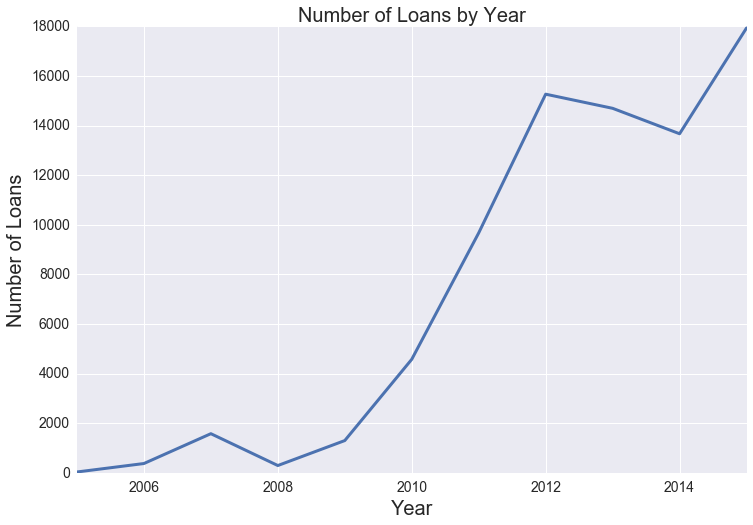

In [66]:
sns.set_style('darkgrid')

fig=plt.figure(figsize=(12,8),facecolor='white')          #open a figure
ax=fig.add_subplot(1,1,1)#, axisbg='white')
ax.plot(loans.year,loans.num_loans,lw=3)
ax.set_ylabel('Number of Loans',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_title('Number of Loans by Year',fontsize=20)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlim(2005,2015)
        
fig.savefig('total_loans_by_year.png')


#df2b.funded_year.value_counts().sort_index().plot(title='Funded Loans by Year');

In [40]:
df2b.sector.value_counts()   # Check out the total number of loans by sector

Agriculture       27567
Food              17982
Retail            12815
Services           6755
Clothing           5501
Transportation     2619
Construction       1395
Health             1023
Education           947
Personal Use        913
Manufacturing       668
Housing             626
Arts                372
Entertainment       114
Wholesale           101
Name: sector, dtype: int64

In [347]:
df2c=df2b.groupby(['sector','funded_year']).size()

In [348]:
df2c1=pd.DataFrame(df2b1.groupby('funded_year').size())


In [349]:
df2c1=df2c1.reset_index()
df2c1.funded_year=df2c1.funded_year.astype(int)
df2c1.loc[:,'Non-Agriculture']=df2c1[0]
df2c1=df2c1.drop(0,axis=1)
df2c1

,funded_year,Non-Agriculture
0,2005,19
1,2006,230
2,2007,1130
3,2008,276
4,2009,1201
5,2010,3113
6,2011,6294
7,2012,11722
8,2013,10503
9,2014,8807


In [350]:
df2c2=df2b2.groupby('funded_year').size()
df2c2=df2c2.reset_index()
df2c2.funded_year=df2c2.funded_year.astype(int)
df2c2.columns
df2c2.loc[:,'Agriculture']=df2c2[0]
df2c2=df2c2.drop(0,axis=1)
df2c2

,funded_year,Agriculture
0,2005,14
1,2006,144
2,2007,447
3,2008,17
4,2009,99
5,2010,1463
6,2011,3379
7,2012,3545
8,2013,4194
9,2014,4864


### The increase is due to increasing support for agriculture 

In [351]:
sec_year=df2c.unstack('sector').fillna(0)   # Sort the columns by values in last row, so that the graph looks good
sec_year.index=sec_year.index.astype(int)   # Set the year values in the index to int
vals=pd.DataFrame(sec_year.loc[sec_year.last_valid_index(),:]).reset_index() # Get the last row and put the column index values into a column by calling .reset_index()
new_cols=vals.sort_values(vals.columns[-1],ascending=False)[vals.columns[0]] # Sort the sector descriptors in decreasing order regarding the 2nd column.
#vals
#new_cols
sec_year=sec_year[new_cols]  # reorder the columns of the dataframe so that it plots and labels in order, in the plot below
sec_year                     # note the values in the last row

sector,Agriculture,Food,Retail,Services,Clothing,Transportation,Construction,Health,Education,Personal Use,Housing,Manufacturing,Arts,Entertainment,Wholesale
funded_year,,,,,,,,,,,,,,,
2005,14.0,4.0,2.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0
2006,144.0,76.0,55.0,38.0,24.0,5.0,8.0,3.0,0.0,0.0,7.0,2.0,12.0,0.0,0.0
2007,447.0,408.0,247.0,166.0,146.0,21.0,26.0,38.0,1.0,0.0,10.0,21.0,43.0,1.0,2.0
2008,17.0,97.0,48.0,32.0,54.0,5.0,6.0,14.0,0.0,0.0,4.0,4.0,9.0,2.0,1.0
2009,99.0,328.0,303.0,212.0,186.0,57.0,12.0,20.0,14.0,0.0,11.0,36.0,9.0,5.0,8.0
2010,1463.0,853.0,814.0,501.0,377.0,184.0,100.0,37.0,45.0,5.0,35.0,101.0,32.0,10.0,19.0
2011,3379.0,1911.0,1645.0,967.0,704.0,332.0,264.0,75.0,82.0,22.0,84.0,122.0,58.0,12.0,16.0
2012,3545.0,4002.0,3038.0,1544.0,1278.0,658.0,299.0,115.0,238.0,127.0,167.0,130.0,56.0,47.0,23.0
2013,4194.0,3853.0,2303.0,1242.0,1021.0,484.0,234.0,286.0,248.0,499.0,148.0,95.0,53.0,16.0,21.0


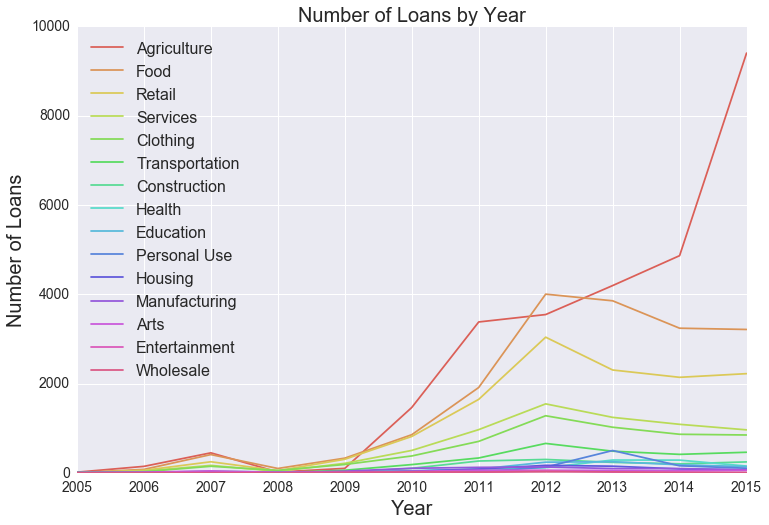

In [149]:
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette("hls",15))

fig=plt.figure(figsize=(12,8),facecolor='white')          #open a figure
ax=fig.add_subplot(1,1,1)#, axisbg='white')
snsplot=sec_year.plot(title='Number of Loans per Sector',ax=ax,color=color1)
start,end=ax.get_xlim()                     #get the default tics and set one for each year
ax.xaxis.set_ticks(np.arange(start,end+1,1))
ax.set_ylabel('Number of Loans',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_title('Number of Loans by Year',fontsize=20)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlim(2005,2015)

ax.legend(loc='best', prop={'size':16})
        
fig.savefig('loans_by_sector-year.png')




#df2c.unstack('sector').fillna(0).plot(title='Number of Loans per Sector');

In [153]:
sectors=df2c.unstack('sector').fillna(0)
sectors=sectors.reset_index()
sectors.funded_year=sectors.funded_year.astype(int)
sectors.head()

sector,funded_year,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale
0,2005,14.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,5.0,1.0,0.0,2.0,5.0,0.0,0.0
1,2006,144.0,12.0,24.0,8.0,0.0,0.0,76.0,3.0,7.0,2.0,0.0,55.0,38.0,5.0,0.0
2,2007,447.0,43.0,146.0,26.0,1.0,1.0,408.0,38.0,10.0,21.0,0.0,247.0,166.0,21.0,2.0
3,2008,17.0,9.0,54.0,6.0,0.0,2.0,97.0,14.0,4.0,4.0,0.0,48.0,32.0,5.0,1.0
4,2009,99.0,9.0,186.0,12.0,14.0,5.0,328.0,20.0,11.0,36.0,0.0,303.0,212.0,57.0,8.0


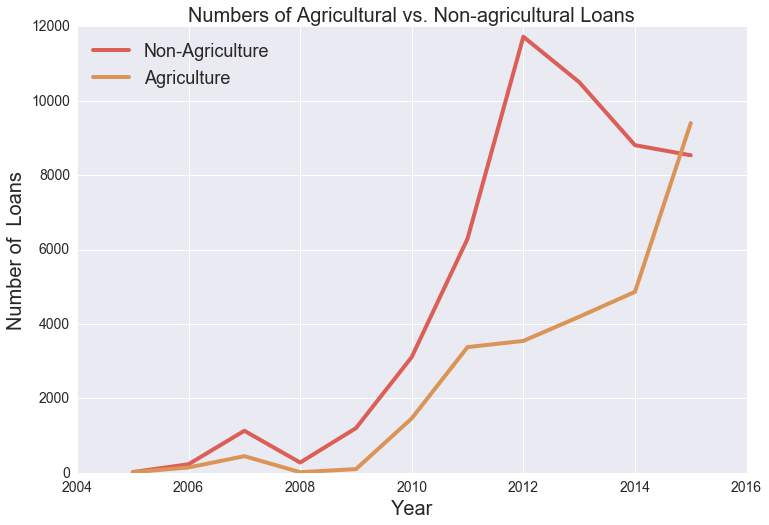

In [159]:
fig=plt.figure(figsize=(12,8),facecolor='white')          #open a figure
ax=fig.add_subplot(1,1,1)#, axisbg='white')
ax.set_title('Numbers of Agricultural vs. Non-agricultural Loans',fontsize=20)
ax.spines['bottom'].set_color('red')
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Number of  Loans',fontsize=20)
year=np.asarray(df2c1.funded_year.astype(int))
ax.plot(df2c1.funded_year, df2c1['Non-Agriculture'],linewidth=4)
ax.plot(df2c2.funded_year, df2c2['Agriculture'],linewidth=4)
ax.ticklabel_format(useOffset=False)
ax.legend(loc='best', prop={'size':18})         #display a legend
for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
                tick.label.set_fontsize(14)
;
fig.savefig('agri_vs_non_agri.png')

In [49]:
df2c.unstack('sector').fillna(0)

sector,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale
funded_year,,,,,,,,,,,,,,,
2005.0,14.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,5.0,1.0,0.0,2.0,5.0,0.0,0.0
2006.0,144.0,12.0,24.0,8.0,0.0,0.0,76.0,3.0,7.0,2.0,0.0,55.0,38.0,5.0,0.0
2007.0,447.0,43.0,146.0,26.0,1.0,1.0,408.0,38.0,10.0,21.0,0.0,247.0,166.0,21.0,2.0
2008.0,17.0,9.0,54.0,6.0,0.0,2.0,97.0,14.0,4.0,4.0,0.0,48.0,32.0,5.0,1.0
2009.0,99.0,9.0,186.0,12.0,14.0,5.0,328.0,20.0,11.0,36.0,0.0,303.0,212.0,57.0,8.0
2010.0,1463.0,32.0,377.0,100.0,45.0,10.0,853.0,37.0,35.0,101.0,5.0,814.0,501.0,184.0,19.0
2011.0,3379.0,58.0,704.0,264.0,82.0,12.0,1911.0,75.0,84.0,122.0,22.0,1645.0,967.0,332.0,16.0
2012.0,3545.0,56.0,1278.0,299.0,238.0,47.0,4002.0,115.0,167.0,130.0,127.0,3038.0,1544.0,658.0,23.0
2013.0,4194.0,53.0,1021.0,234.0,248.0,16.0,3853.0,286.0,148.0,95.0,499.0,2303.0,1242.0,484.0,21.0


In [173]:
df2c1= df2b[(df2b['sector']=='Agriculture')&((df2b.prop_female==1)|(df2b.prop_female==0))].groupby(['prop_female','funded_year'],as_index=False).size()
df2c1=df2c1.unstack('prop_female').reset_index()
df2c1.loc[:,'Female']=df2c1.iloc[:,2]
df2c1.loc[:,'Male']=df2c1.iloc[:,1]
cols=[1,2]
df2c1=df2c1.drop(df2c1.columns[cols],axis=1)
df2c1.funded_year=df2c1.funded_year.astype(int)
df2c1.columns=['funded_year','Women','Men']
df2c1

,funded_year,Women,Men
0,2005,13,1
1,2006,133,11
2,2007,384,63
3,2008,7,8
4,2009,55,44
5,2010,591,872
6,2011,1247,1551
7,2012,1653,1552
8,2013,1776,1741
9,2014,2679,1531


### Growth in Agriculture Sector Loans: More Loans to Women

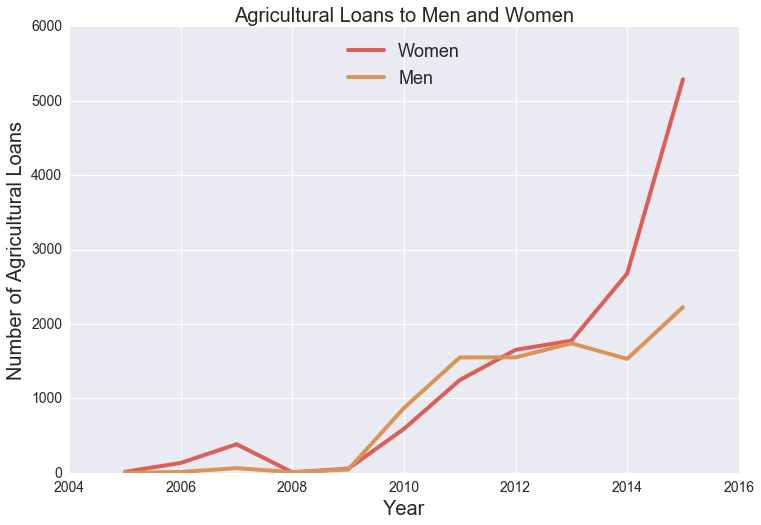

In [174]:
fig=plt.figure(figsize=(12,8),facecolor='white')          #open a figure
ax=fig.add_subplot(1,1,1)#, axisbg='white')
ax.spines['bottom'].set_color('red')
ax.set_title('Agricultural Loans to Men and Women',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Number of Agricultural Loans',fontsize=20)
year=np.asarray(df2c1.funded_year.astype(int))

ax.plot(year, df2c1.Women,linewidth=4)
ax.plot(year, df2c1.Men,linewidth=4)
ax.ticklabel_format(useOffset=False)

#ax.plot(df2c1.iloc[:,0], df2c1.iloc[:,1],linewidth=4)
#ax.plot(df2c1.iloc[:,0], df2c1.iloc[:,2],linewidth=4)

ax.legend(loc='upper center', prop={'size':18})         #display a legend
for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
                tick.label.set_fontsize(14)

fig.savefig('Ag_loans_men_women.png')

In [164]:
df2c1= df2b[((df2b.prop_female==1)|(df2b.prop_female==0))].copy()
df2c1.funded_year=df2c1.funded_year.astype(int)
df2c1.funded_year.value_counts()
#for sector in df2c1['sector'].unique():
#    print 'this is sector', sector

2015    15879
2012    14926
2013    13873
2014    12814
2011     9092
2010     4576
2007     1573
2009     1299
2006      374
2008      257
2005       33
Name: funded_year, dtype: int64

## A table for loans in agriculture, by gender and year

In [165]:
df2c1= df2b[((df2b.prop_female==1)|(df2b.prop_female==0))].copy()
df2c1=df2c1[df2c1.sector=='Agriculture'].groupby(['prop_female','funded_year'],as_index=False).size()
df2c1=df2c1.unstack('prop_female').reset_index()
df2c1.loc[:,'Female']=df2c1.iloc[:,2]
df2c1.loc[:,'Male']=df2c1.iloc[:,1]
cols=[1,2]
df2c1=df2c1.drop(df2c1.columns[cols],axis=1)
df2c1

prop_female,funded_year,Female,Male
0,2005.0,13,1
1,2006.0,133,11
2,2007.0,384,63
3,2008.0,7,8
4,2009.0,55,44
5,2010.0,591,872
6,2011.0,1247,1551
7,2012.0,1653,1552
8,2013.0,1776,1741
9,2014.0,2679,1531


In [166]:
import matplotlib.ticker as ticker          #This allows more precise control of tick labels

## The number of loans by sector and gender over time
#### Note that the y-axis differs among panels within the figure

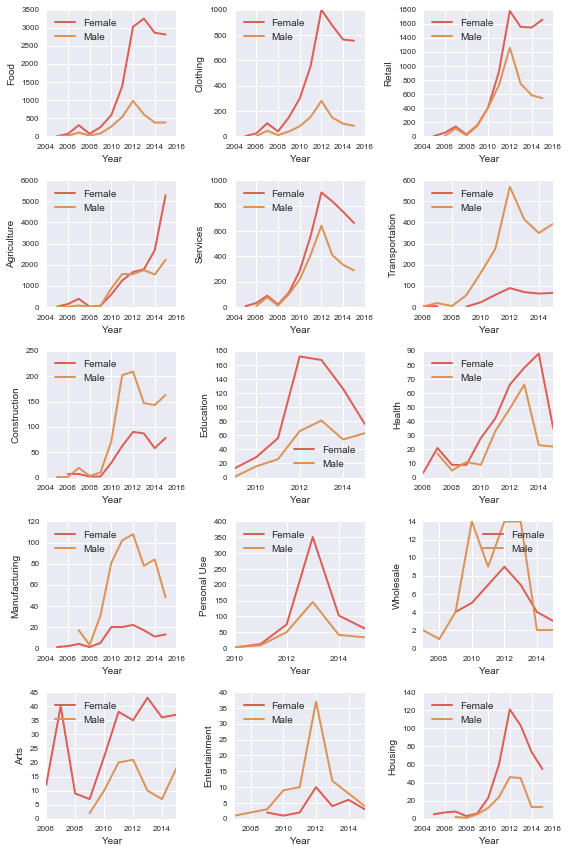

In [175]:

fig=plt.figure(figsize=(8,12),facecolor='white')    #open a figure, rowdim,coldim      
df2c1= df2b[((df2b.prop_female==1)|(df2b.prop_female==0))].copy()
i=0
for sector in df2c1['sector'].unique():
    
    df2c1.funded_year=df2c1.funded_year.astype(int)
    df2c1a=df2c1[df2c1.sector== sector].groupby(['prop_female','funded_year'],as_index=False).size()
    df2c1a=df2c1a.unstack('prop_female').reset_index()
    df2c1a.loc[:,'Female']=df2c1a.iloc[:,2]
    df2c1a.loc[:,'Male']=df2c1a.iloc[:,1]
    cols=[1,2]
    df2c1a=df2c1a.drop(df2c1a.columns[cols],axis=1)

    i=i+1
    ax=fig.add_subplot(5,3,i)#, axisbg='white')
    ax.spines['bottom'].set_color('red')
    ax.set_xlabel('Year',fontsize=10)
    ax.set_ylabel(sector,fontsize=10)

    ax.plot(df2c1a.iloc[:,0], df2c1a.iloc[:,1],linewidth=2)
    ax.plot(df2c1a.iloc[:,0], df2c1a.iloc[:,2],linewidth=2)
    ax.ticklabel_format(useOffset=False)                    # This was necessary to print full years on some plots
    tick_spacing=2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))  # Here is how you set tick spacing

    ax.legend(loc='best', prop={'size':10})         #display a legend
    for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
        tick.label.set_fontsize(8) 
    for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(8)

fig.tight_layout()
fig.savefig('gender_by_sector.png')



In [56]:
df2c1= df2b[((df2b.prop_female==1)|(df2b.prop_female==0))].groupby(['sector','prop_female','funded_year'],as_index=False).size()
df2c1=df2c1.unstack('prop_female').reset_index()
df2c1['funded_year']=df2c1['funded_year'].astype('int')
#df2c1.index.names=['index']
#df2c1.loc[:,'Female']=df2c1.iloc[:,2]
#df2c1.loc[:,'Male']=df2c1.iloc[:,1]
#cols=[1,2]
#df2c1=df2c1.drop(df2c1.columns[cols],axis=1)
df2c1.index.name='index'
df2c1.sector.unique()
#df2c1[df2c1.sector=='Agriculture'].plot(x='funded_year')

array([u'Agriculture', u'Arts', u'Clothing', u'Construction', u'Education',
       u'Entertainment', u'Food', u'Health', u'Housing', u'Manufacturing',
       u'Personal Use', u'Retail', u'Services', u'Transportation',
       u'Wholesale'], dtype=object)

## Loan sizes and default rates

In [177]:
df2d=df2a[(df2a.funded_year.isnull()==False)&(df2a.funded_year!=2016.0)]

In [193]:
arr =np.array(df2d.funded_amount[df2d.funded_amount<=2500])
loans=pd.cut(arr,bins=[-0.1,250,500,750,1000,1500,2000,2500],labels=['<250','<500','<750','<1000','<1500','<2000','<2500'])

### Most Loans Are Less Than 500 US Dollars

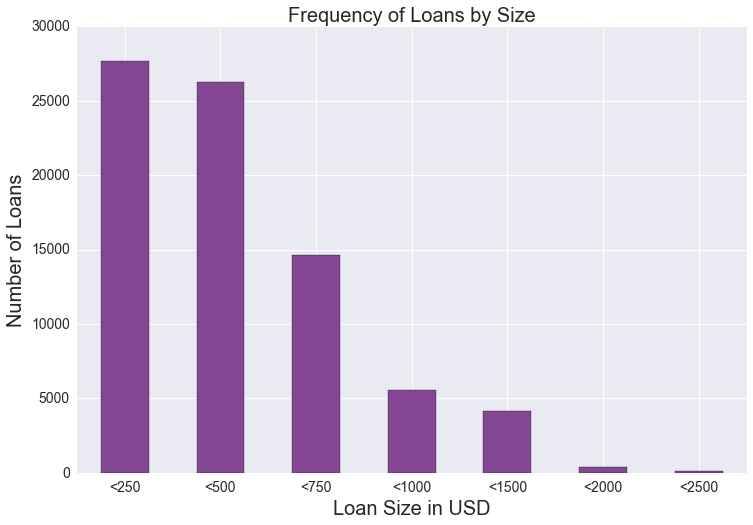

In [207]:
sns.set_palette(sns.color_palette("PRGn"))
#sns.palplot(sns.color_palette("PRGn",15)[0:7])


sns.set_style('darkgrid')
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
vc=loans.value_counts()
vc.plot(kind='bar',ax=ax)
ax.set_xlabel("Loan Size in USD",fontsize=20)
ax.set_ylabel("Number of Loans",fontsize=20)
ax.set_title("Frequency of Loans by Size", fontsize=20)

for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
        tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)

fig.savefig("loan_freq_by_size.png")
#plt.show()

#loans.value_counts().plot(kind='bar',title='Most Loans Are Less Than 500 USD').set_ylabel('Number Loans');

### Defaults On Loans Are Rare

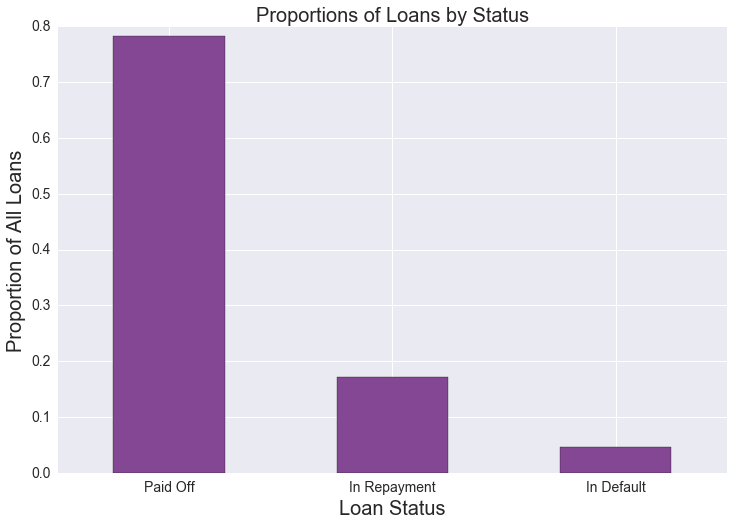

In [208]:
sns.set_palette(sns.color_palette("PRGn"))
sns.set_style('darkgrid')

series1=df2d.status.value_counts()/df2d.status.value_counts().sum()

fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
series1.plot(kind='bar',ax=ax)
ax.set_title("Proportions of Loans by Status",fontsize=20)
ax.set_ylabel("Proportion of All Loans",fontsize=20)
ax.set_xlabel("Loan Status",fontsize=20)

ticklabels=["Paid Off","In Repayment","In Default"]
ax.set_xticklabels(ticklabels,rotation=0,fontsize=14)

for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(14)
        
fig.savefig("frequency_loan_status.png")



In [210]:
df2e=df2b[(df2b.num_borrowers==1)&((df2b.prop_female==1)|(df2b.prop_female==0))]

In [211]:
sex_status=df2e.groupby(['status','prop_female']).size().unstack('status')

In [212]:
sex_status['total']=sex_status.paid+sex_status.in_repayment+sex_status.defaulted

In [213]:
sex_status['prop_defaulted']= sex_status.defaulted/sex_status.total
sex_status

status,defaulted,in_repayment,paid,total,prop_defaulted
prop_female,,,,,
0.0,1054,3779,20869,25702,0.041008
1.0,1933,8566,37395,47894,0.040360


### Default Rates For Men And Women Are Similar

In [239]:
from itertools import cycle, islice                   # just for experimenting with some custom colors
colors=sns.set_palette(sns.color_palette("PRGn"))
mycolors=list(islice(cycle(sns.color_palette("PRGn")),None,2))

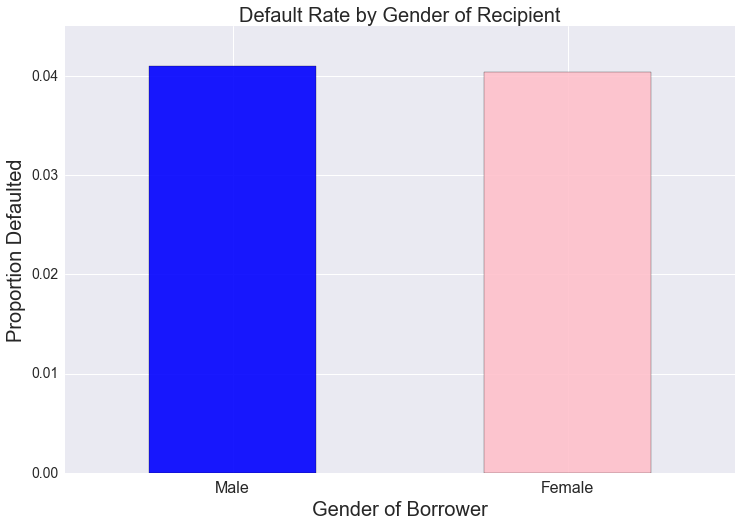

In [269]:

colors=sns.set_palette(sns.color_palette("PRGn"))
sns.set_style('darkgrid')

fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
bars=sex_status.iloc[:,4].plot(kind='bar',ax=ax,color=['blue','pink'],alpha=0.9,yticks=np.arange(0,0.045,0.01)) #sns.color_palette("PRGn")[2])
ax.set_ylabel('Proportion Defaulted',fontsize=20)
ax.set_title('Default Rate by Gender of Recipient',fontsize=20)
ticklabels=['Male','Female']
ax.set_xticklabels(ticklabels,rotation=0, fontsize=16)
ax.set_xlabel('Gender of Borrower',fontsize=20)

for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(14)

fig.savefig('default_by_gender.png')



In [64]:
df2f=df2b[['num_borrowers','funded_amount','lender_count']].groupby('num_borrowers',as_index=False).mean()
df2f.head()

,num_borrowers,funded_amount,lender_count
0,1,435.163236,13.878871
1,2,380.457380,12.004158
2,3,817.307692,26.459276
3,4,1205.188679,38.504717
4,5,1551.394231,50.407692


### Larger Loans Involve More Lenders

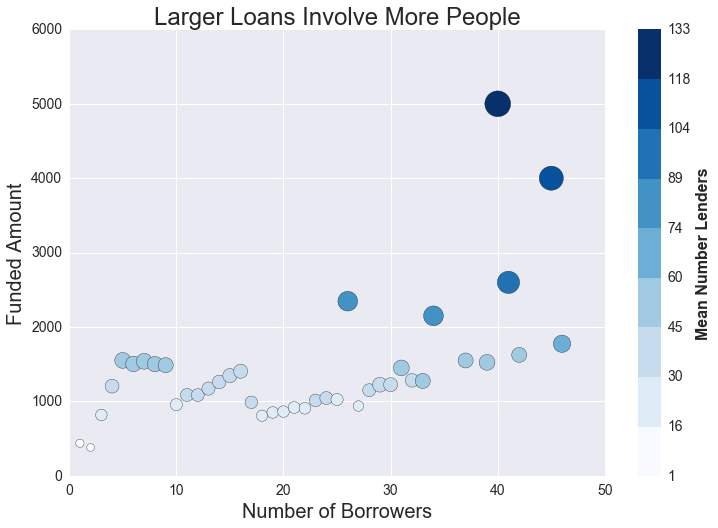

In [29]:
color=df2f['lender_count']#/df2f['lender_count'].max()   #define the colors on raw values

fig=plt.figure(figsize=(12,8)) #,facecolor='white')          #open a figure
ax=fig.add_subplot(1,1,1) #,axisbg='white')                #open a plot in the figure 
ax.set_xlabel('Number of Borrowers',fontsize=20)
ax.set_ylabel('Funded Amount',fontsize=20)
ax.set_title('Larger Loans Involve More People',fontsize=24)
#ax.spines['bottom'].set_color('red')                   #This does not work here
for child in ax.get_children():
    if isinstance(child, mpl.spines.Spine):
        child.set_color('black')
ax.grid(True,color='white')
for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
                tick.label.set_fontsize(14)
                #tick.label.set_rotation('vertical')    # you can rotate the tick labels

cmap=plt.cm.Blues                                        #define a colormap, see http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/Show_colormaps
                                                         
bounds=np.linspace(1,df2f['lender_count'].max(),10,      #determine the breaks for the intervals in the colorbar
                   endpoint=True).round()
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)           #adjust the color intervals to the breaks
scat = plt.scatter(df2f.num_borrowers,df2f.funded_amount,c=color,s=(df2f.lender_count * 5),norm=norm,cmap=cmap)
ax.set_xlim(0,50)
cb=fig.colorbar(scat,ax=ax)                           #plot the colorbar
cb.ax.tick_params(labelsize=14)
cb.set_label(label='Mean Number Lenders',size=16,weight='bold')
#cb.set_label(label='a label',weight='bold')
fig.savefig('funded_amount_vs_num_borrowers.png')
plt.show()

## 3. Correlations, Insights, Questions and Hypotheses
#### Most Kiva loans in Kenya are in the agricultural, food, and retail sectors. The loans vary greatly in size, ranging from 25 to 50,000 USD.  The majority of loans have been for less than 500 USD. The number of lenders that contribute to a loan increases with loan size, which certainly is not surprising.  The number of loans made per year in Kenya decreased for two years until 2014, but then rebounded substantially in 2015.  This rebound was associated with an increase in the number of agricultural loans made to women.  The rate of default on loans is about 5%, with the default rate on single-borrower loans being roughly equal.
**Questions and Hypotheses**: 
>What activities are subsumed by agricultural loans to women? I predict that they are primarily used for materials to increase productivity, such as newer seed varieties and fertilizer.

>Do agricultural loans to women differ somehow from similar loans to men? It may be that women are commercializing household gardens, which in the data base may be described differently from loans to men

>Some loans expire, having never been funded by Kiva donors.  Do these loans or the applicants somehow differ from the loans that recieve Kiva funding? It may be that there is *something about the loan that raises doubts* about the use to which the funds would go.

>Is there anything that characterizes the loans or borrowers who end up in default? Are they *randomly distributed among loans of all sizes*?  Are they *geographically clustered*?  I predict that defaults are not randomly distributed among all loans, but I do not yet see a basis for making a distinct hypothesis as to how they might be characterized.

>How do loans with multiple borrowers differ from loans with only a single borrower?  It may be that these loans are for more-complicated undertakings, ones that necessitate a larger social group or have a complicated administrative structure.

>How are the funded loans distributed around Kenya? The increase in agriculture-sector loans to womend suggests that there may be increasing focus on rural areas.

**Narrative**:
>The Kiva loan program represents thousands of loans within Kenya.  These loans are generally small (<500 USD) and impact a range of sectors in Kenyan society.  The default rate on loans is about 5%, and men and women borrowers have similar risk of defaults.  Recently, more loans have been given to women in the agricultural sector. These loans appear to be driving the overall increase in Kiva loans over the last two years.  It would be interesting to know how these agricultural loans to women are being used, and if they indicate an increasingly rural emphasis in Kiva microloan activity.  To do this, I am first looking at the text descriptions of the borrower and his/her situation.




In [28]:
df2b=df2b[df2b.name!='Anonymous']

In [67]:
df2b.shape

(71443, 48)

### The length of the text descriptions of the loan seeker and his or her activities varies substantially.  Here is a plot of the distribution of number of text characters in the description and a kernel smoother.

In [43]:
arr =np.array(df2b.funded_amount[df2d.funded_amount<=2500])
loans=pd.cut(arr,bins=np.arange(0,5250,250,labels=np.arange(250,5250,250)))

NameError: name 'df2d' is not defined

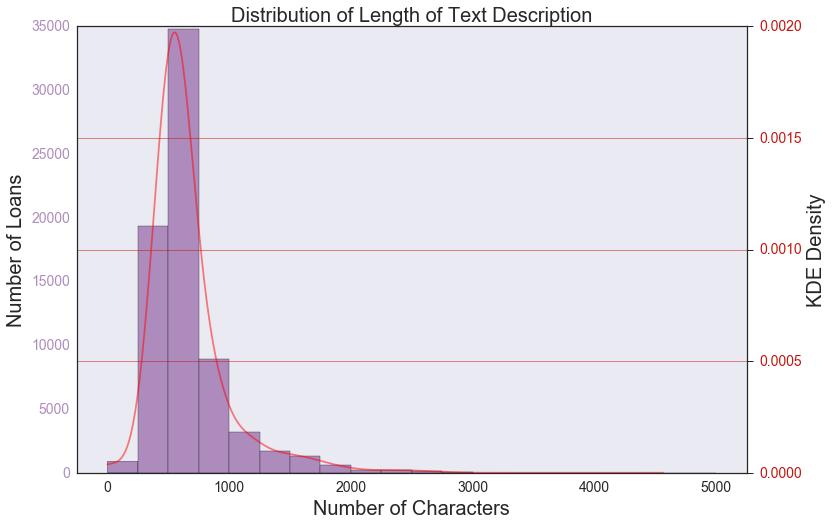

In [40]:
from scipy import stats       #  DON'T RUN THIS, RUN THE ONE BELOW

def my_kde_bandwidth(obj, fac=3./1):   #Scott's Rule, multiplied by a constant factor.#
    return np.power(obj.n, -1./(obj.d+4)) * fac


fig=plt.figure(figsize=(12,8))
with sns.axes_style("dark"):
    ax=fig.add_subplot(1,1,1)
with sns.axes_style("ticks"):   # this plots tick marks but leaves grid off
    ax1=ax.twinx()              # this creates a second y axis on the right hand side
dat=df2b['texts.en'].str.len()
kde=stats.gaussian_kde(dat, bw_method=my_kde_bandwidth)  # define the KDE
xval=np.linspace(0,max(dat),num=500)                     # set the intervals for the KDE
#with sns.axes_style("white"):
col=sns.color_palette("PRGn",15)[3]      # Set some colors here, by choosing from a palette
col2=sns.color_palette("OrRd",10)[8]
bins=np.arange(0,5250,250)
counts,bins,patches=ax.hist(dat,bins=bins,facecolor=col)                       # plot the histogram as frequencies
ax.set_xlim(-250,5250)
ax1.plot(xval,kde(xval),'k-',color='r',alpha=0.5)        # plot the KDE
ax1.grid(which='major',color=col2,linewidth=1.0,alpha=0.5)  # Turn on a grid and set the grid color
for label in ax.get_yticklabels():                       # set the label colors
    label.set_color(col)
    

for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(14)
        
for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
        tick.label.set_fontsize(14)
ax.set_title('Distribution of Length of Text Description',fontsize=20)
ax.set_ylabel('Number of Loans',fontsize=20)
ax.set_xlabel('Number of Characters',fontsize=20)
ax1.set_ylabel('KDE Density', fontsize=20)


for label in ax1.get_yticklabels():                 #set the size and color of the tick labels on the right y-axis
        label.set_fontsize(14)                      # Of course, the similar steps above could also have been consolidated
        label.set_color(col2)

plt.show()
#fig.savefig('dist_text_descrip_len.png')


#df2b['texts.en'].str.len().hist(bins=20);

In [49]:
dat=df2b['texts.en'].str.len()
arr =np.array(dat)
loans=pd.cut(arr,bins=np.arange(0,5250,250),labels=np.arange(250,5250,250))
loans[0:3]

[1000, 750, 750]
Categories (20, int64): [250 < 500 < 750 < 1000 ... 4250 < 4500 < 4750 < 5000]

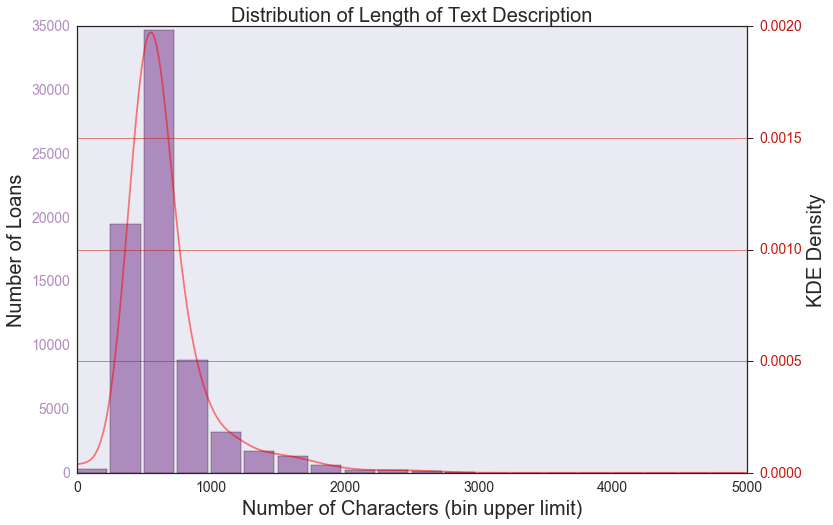

In [65]:
from scipy import stats

def my_kde_bandwidth(obj, fac=3./1):   #Scott's Rule, multiplied by a constant factor.#
    return np.power(obj.n, -1./(obj.d+4)) * fac


fig=plt.figure(figsize=(12,8))
with sns.axes_style("dark"):
    ax=fig.add_subplot(1,1,1)
with sns.axes_style("ticks"):   # this plots tick marks but leaves grid off
    ax1=ax.twinx()              # this creates a second y axis on the right hand side
col=sns.color_palette("PRGn",15)[3]      # Set some colors here, by choosing from a palette
col2=sns.color_palette("OrRd",10)[8]
vc=loans.value_counts()
N=len(vc)
locs=np.arange(250,5250,250)-250
width=225

kde=stats.gaussian_kde(dat, bw_method=my_kde_bandwidth)  # define the KDE
xval=np.linspace(0,5000,num=500)
ax.bar(locs,vc,width=width,facecolor=col)
#vc.plot(kind='bar',ax=ax)
# set the intervals for the KDE
#with sns.axes_style("white"):


ax1.plot(xval,kde(xval),'k-',color='r',alpha=0.5)        # plot the KDE
ax1.grid(which='major',color=col2,linewidth=1.0,alpha=0.5)  # Turn on a grid and set the grid color
for label in ax.get_yticklabels():                       # set the label colors
    label.set_color(col)
    

for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(14)
        
for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
        tick.label.set_fontsize(14)
ax.set_title('Distribution of Length of Text Description',fontsize=20)
ax.set_ylabel('Number of Loans',fontsize=20)
ax.set_xlabel('Number of Characters (bin upper limit)',fontsize=20)
ax1.set_ylabel('KDE Density', fontsize=20)


for label in ax1.get_yticklabels():                 #set the size and color of the tick labels on the right y-axis
        label.set_fontsize(14)                      # Of course, the similar steps above could also have been consolidated
        label.set_color(col2)

plt.show()
fig.savefig('dist_text_descrip_len.png')


#df2b['texts.en'].str.len().hist(bins=20);

In [55]:
vc  # number of counts per bin, above

250       280
500     19515
750     34694
1000     8880
1250     3203
1500     1677
1750     1290
2000      629
2250      241
2500      226
2750      136
3000       30
3250        4
3500        4
3750        1
4000        1
4250        2
4500        0
4750        1
5000        0
dtype: int64

### Here are the average length (characters) of the text descriptions by year

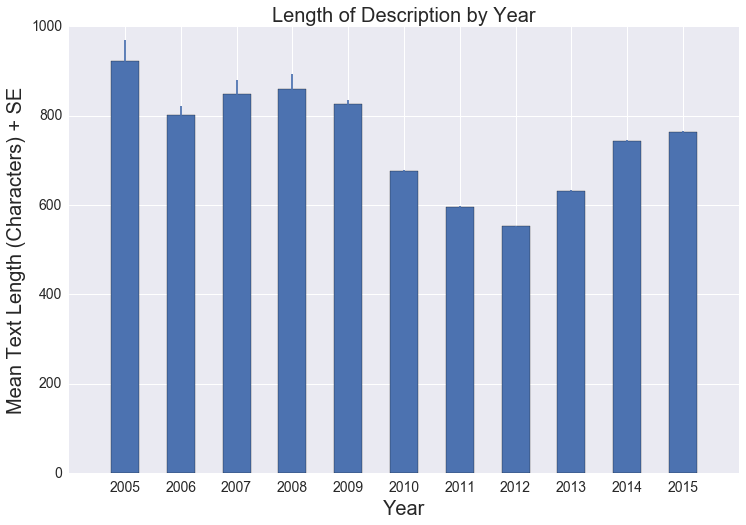

In [68]:
dat=pd.DataFrame(df2b['texts.en'].str.len().groupby(df2b.funded_year).mean())
dat.index=dat.index.astype(int)
dat.reset_index(inplace=True)
dat2=pd.DataFrame(df2b['texts.en'].str.len().groupby(df2b.funded_year).std())
dat2.index=dat.index.astype(int)
dat2.reset_index(inplace=True)
dat3=pd.DataFrame(df2b['texts.en'].str.len().groupby(df2b.funded_year).size())
dat3.index=dat.index.astype(int)
dat3.reset_index(inplace=True)
std_error=dat2['texts.en']/np.sqrt(dat3[0])


fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
ind=np.arange(11)
width=0.5

ax.set_xlim([-1,11])
ax.bar(ind-0.25,dat.iloc[:,1],width,yerr=std_error)
#ax.xticks(ind,1)
ax.xaxis.set_ticks(ind)
ticklabels=dat.funded_year
ax.set_xticklabels(ticklabels)
ax.set_ylabel("Mean Text Length (Characters) + SE",fontsize=20)
ax.set_xlabel("Year",fontsize=20)
ax.set_title("Length of Description by Year",fontsize=20)

for tick in ax.yaxis.get_major_ticks():                 #set the size of the tick labels on the y-axis
        tick.label.set_fontsize(14)
        
for tick in ax.xaxis.get_major_ticks():                 #set the size of the tick labels on the x-axis
        tick.label.set_fontsize(14)

fig.savefig('mean_text_len_by_year.png')
plt.show()





#df2b['texts.en'].str.len().groupby(df2b.funded_year).mean().plot(kind='bar')

In [475]:
dat2['texts.en']/np.sqrt(dat3[0])

0     66.945191
1     23.044559
2     10.374423
3     30.470603
4      7.608434
5      3.184317
6      2.279823
7      1.820511
8      2.797189
9      3.987253
10     3.327128
dtype: float64

In [69]:
dat3[0]

0        29
1       183
2       295
3       151
4      1296
5      4468
6      9395
7     14489
8     13601
9     13006
10    14530
Name: 0, dtype: int64

In [71]:
import pkgutil
import nltk
#from wordcloud import wordcloud as wcld

In [72]:
import unicodedata as uni

In [73]:
df2b['texts.en'].iloc[0]

u'Francis has a mixed farm that produces tea, maize, tomatoes, onions, beans and bananas, which are all sold at the local market. He has been farming for fifteen years in the town of Kisii in western Kenya and employs one farmhand. He also owns and operates a butcher shop in the same location.\r\n\r\nFrancis is 47 years old. He is married and has been blessed with four children who are now between the ages of 7 and 22. All of the children attend school.\r\n\r\nFrancis recently repaid his second loan from Juhudi Kilimo and has requested this loan of 80,000KES to expand his butcher shop. The income from this investment will enable him to take his son to college and improve the livelihood of his family. The major challenges he is facing in farming are unpredictable weather conditions and diseases that affect his production. In future, he would like to do large-scale farming and own a string of butcheries to supply meat to institutions.\r\n\r\n'

#### Now change the unicode text to the string type

In [74]:
new_en=[]
for i in range(0,len(df2b['texts.en'])):
    new_en.append(uni.normalize('NFKD',df2b['texts.en'].iloc[i]).encode('ascii','ignore'))

In [75]:
df2b.loc[:,'texts.en']=pd.Series(new_en,index=df2b.index)   ##  This is important, or the texts will be put 
                                                            ##  in the wrong place

In [76]:
df2b['texts.en'].iloc[0]

'Francis has a mixed farm that produces tea, maize, tomatoes, onions, beans and bananas, which are all sold at the local market. He has been farming for fifteen years in the town of Kisii in western Kenya and employs one farmhand. He also owns and operates a butcher shop in the same location.\r\n\r\nFrancis is 47 years old. He is married and has been blessed with four children who are now between the ages of 7 and 22. All of the children attend school.\r\n\r\nFrancis recently repaid his second loan from Juhudi Kilimo and has requested this loan of 80,000KES to expand his butcher shop. The income from this investment will enable him to take his son to college and improve the livelihood of his family. The major challenges he is facing in farming are unpredictable weather conditions and diseases that affect his production. In future, he would like to do large-scale farming and own a string of butcheries to supply meat to institutions.\r\n\r\n'

In [26]:
from nltk.corpus import stopwords
#nltk.download()                     # I did this once already

In [69]:
stop = stopwords.words('english')

In [70]:
stop.extend(('.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','/','-','.<','<','>','P','p','000'))

In [71]:
len(stop)

175

### Now generate tokens that do not have the stop words, as defined above.

In [81]:
frequency_words_wo_stop = {}

In [82]:
def generate_word_frequency(row):
    data = row['texts.en']
    tokens = nltk.wordpunct_tokenize(data)
    #print tokens
    token_list = []
    for token in tokens:
        if token.lower() not in stop:
            if token.lower() in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token.lower()]
                count = count + 1
                frequency_words_wo_stop[token.lower()] = count
                #print token, frequency_words_wo_stop[token]
            else:
                frequency_words_wo_stop[token] = 1
            token_list.append(token)                #.lower())
    #print token_list
    test= ','.join(token_list)
    #print test
    return test

In [83]:
df2b.loc[:,'tokens']=df2b.apply(generate_word_frequency,axis=1)

In [41]:
df2b.tokens.isnull().astype(int).sum()

0

In [42]:
df2b['tokens'].iloc[0]

'Francis,mixed,farm,produces,tea,maize,tomatoes,onions,beans,bananas,sold,local,market,farming,fifteen,years,town,Kisii,western,Kenya,employs,one,farmhand,also,owns,operates,butcher,shop,location,Francis,47,years,old,married,blessed,four,children,ages,7,22,children,attend,school,Francis,recently,repaid,second,loan,Juhudi,Kilimo,requested,loan,80,000KES,expand,butcher,shop,income,investment,enable,take,son,college,improve,livelihood,family,major,challenges,facing,farming,unpredictable,weather,conditions,diseases,affect,production,future,would,like,large,scale,farming,string,butcheries,supply,meat,institutions'

In [43]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

### Generate the stems based on the tokens

In [44]:
def stem_english(data):
    return porter_stemmer.stem(data['texts.en'])

In [45]:
freq_stems_wo_stop={}

In [46]:
def stem_tokens(row):
    data = row['texts.en']
    tokens = nltk.wordpunct_tokenize(data)
    #print tokens
    stem_list = []
    for token in tokens:
        if token.lower() not in stop:
            stem=porter_stemmer.stem(token.lower())
            if stem in freq_stems_wo_stop:
                count = freq_stems_wo_stop[stem]
                count = count + 1
                freq_stems_wo_stop[stem] = count
                #print token, frequency_words_wo_stop[token]
            else:
                freq_stems_wo_stop[stem] = 1
            stem_list.append(stem)
    #print token_list
    test= ','.join(stem_list)
    #print test
    return test

In [47]:
df2b.loc[:,'stems'] = df2b.apply(stem_tokens,axis=1)

In [48]:
df2b.stems[0:4]

57     franci,mix,farm,produc,tea,maiz,tomato,onion,b...
78     maureen,hardwork,31,year,old,busi,woman,marri,...
81     agn,35,year,old,marri,juliu,run,green,grocer,b...
152    reuben,marri,four,children,support,reuben,intr...
Name: stems, dtype: object

### Run a lemmatizer on the text and save the results in a column

In [88]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [50]:
wordnet_lemmatizer.lemmatize('is',pos='v')

u'be'

In [51]:
def lemmatize_text(data):
    return wordnet_lemmatizer.lemmatize(data['texts.en'])

In [52]:
df2b.loc[:,'lemma']=df2b.apply(lemmatize_text,axis=1)

In [53]:
df2b.lemma.iloc[0:5]

57     Francis has a mixed farm that produces tea, ma...
78     Maureen is a hardworking 31-year-old business ...
81     Agnes is 35 years old and married to Julius. S...
152    Reuben is married and has four children whom t...
158    Elizabeth is 42 years old married to Martin wh...
Name: lemma, dtype: object

### Add additional stop words that can identify the gender of the loan seeker, generate tokens without these words

In [72]:
stop.extend(('she','her','hers','woman','mother','businesswoman','he','him','his','man','father','businessman'))

In [73]:
len(stop)

187

In [56]:
frequency_words_wo_stop_nogen = {}

In [57]:
def generate_word_frequency2(row):
    data = row['texts.en']
    tokens = nltk.wordpunct_tokenize(data)
    #print tokens
    token_list_b = []
    for token in tokens:
        if token.lower() not in stop:
            #if token.lower() in frequency_words_wo_stop_nogen:
            #    count = frequency_words_wo_stop_nogen[token.lower()]
            #    count = count + 1
            #    frequency_words_wo_stop_nogen[token.lower()] = count
            #    #print token, frequency_words_wo_stop_nogen[token]
            #else:
            #    frequency_words_wo_stop_nogen[token.lower()] = 1
            token_list_b.append(token.lower())              
    #print token_list
    #var = ','.join(token_list_b)
    return token_list_b

In [58]:
len(df2b['texts.en'])+1

71444

In [59]:
def new_tokens(row):
    tokens=nltk.wordpunct_tokenize(row['texts.en'])
    token_list_b = []
    for token in tokens:
        if token.lower() not in stop:
            token_list_b.append(token.lower())
    return token_list_b

In [60]:
len(df2b['texts.en'])

71443

In [61]:
#df2b=df2b.drop('tokens_nogen',axis=1)

In [62]:
df2b['texts.en'].iloc[0]

'Francis has a mixed farm that produces tea, maize, tomatoes, onions, beans and bananas, which are all sold at the local market. He has been farming for fifteen years in the town of Kisii in western Kenya and employs one farmhand. He also owns and operates a butcher shop in the same location.\r\n\r\nFrancis is 47 years old. He is married and has been blessed with four children who are now between the ages of 7 and 22. All of the children attend school.\r\n\r\nFrancis recently repaid his second loan from Juhudi Kilimo and has requested this loan of 80,000KES to expand his butcher shop. The income from this investment will enable him to take his son to college and improve the livelihood of his family. The major challenges he is facing in farming are unpredictable weather conditions and diseases that affect his production. In future, he would like to do large-scale farming and own a string of butcheries to supply meat to institutions.\r\n\r\n'

In [63]:
tokens_nogen=[]
for n in range(0,len(df2b['texts.en'])):  
    #print n
    tokens=nltk.wordpunct_tokenize(df2b['texts.en'].iloc[n])
    token_list_b = []
    for token in tokens:
        if token.lower() not in stop:
            token_list_b.append(token.lower())
    tokens_nogen.append(token_list_b)


In [64]:
df2b.loc[:,'tokens_nogen']=pd.Series(tokens_nogen, index=df2b.index)

In [65]:
pos_tags=[]
for i in range(0,len(df2b.tokens_nogen)):
    pos_tags.append(nltk.pos_tag(df2b.tokens_nogen.iloc[i]))

df2b.loc[:,'pos_tags']=pd.Series(pos_tags,index=df2b.index)
    

In [66]:
df2b['tokens'].iloc[0]

'Francis,mixed,farm,produces,tea,maize,tomatoes,onions,beans,bananas,sold,local,market,farming,fifteen,years,town,Kisii,western,Kenya,employs,one,farmhand,also,owns,operates,butcher,shop,location,Francis,47,years,old,married,blessed,four,children,ages,7,22,children,attend,school,Francis,recently,repaid,second,loan,Juhudi,Kilimo,requested,loan,80,000KES,expand,butcher,shop,income,investment,enable,take,son,college,improve,livelihood,family,major,challenges,facing,farming,unpredictable,weather,conditions,diseases,affect,production,future,would,like,large,scale,farming,string,butcheries,supply,meat,institutions'

### Now construct tf-idf

In [67]:
tokens_list=df2b['tokens'].tolist()

In [68]:
df2b['tokens'].iloc[0]

'Francis,mixed,farm,produces,tea,maize,tomatoes,onions,beans,bananas,sold,local,market,farming,fifteen,years,town,Kisii,western,Kenya,employs,one,farmhand,also,owns,operates,butcher,shop,location,Francis,47,years,old,married,blessed,four,children,ages,7,22,children,attend,school,Francis,recently,repaid,second,loan,Juhudi,Kilimo,requested,loan,80,000KES,expand,butcher,shop,income,investment,enable,take,son,college,improve,livelihood,family,major,challenges,facing,farming,unpredictable,weather,conditions,diseases,affect,production,future,would,like,large,scale,farming,string,butcheries,supply,meat,institutions'

In [314]:
frequency_words = {}
for data in tokens_list:
    data = data.replace("[","")
    data = data.replace("]","")
    data = data.replace("'","")
    data_list = data.split(',')
    #print(data_list)
    for token in data_list:
        token = token.rstrip()
        token = token.lstrip()
        if token not in stop:
            if token in frequency_words:
                count = frequency_words[token]
                count = count + 1
                frequency_words[token] = count
            else:
                frequency_words[token] = 1

In [327]:
df_tfidf = pd.DataFrame(data=list(frequency_words.items()),columns=['word','tf'])

In [328]:
df_tfidf.head()

,word,tf
0,,3821
1,Redemter,8
2,Dago,1
3,woods,1
4,hanging,4


In [329]:
df_tfidf.sort_values(ascending=False, by = "tf", inplace=True)

In [332]:
df_tfidf.head()

,word,tf
26633,business,143407
25078,loan,108191
645,years,93524
28738,children,68977
3343,000,47908


In [5]:
filename='../data/df2b.pickle'
handle=open(filename,'r')
df2b=pk.load(handle)
handle.close()

In [6]:
tuple(map(str,range(0,5)))

('0', '1', '2', '3', '4')

In [7]:
from nltk.corpus import stopwords
#nltk.download()                     # I did this once already

In [102]:
names=df2b.name.unique()

#tuple(pd.Series(names))

In [103]:
names= [x.lower() for x in names]

In [104]:
#names.sort()
tuple(names[1:8])

(u'maureen',
 u'agnes',
 u'reuben mwilu',
 u'elizabeth ndunge',
 u'elizabeth',
 u'ruth',
 u'anonymous')

## Include as stop words the common words that indicate the gender of the borrower.  Also include all the names in the data.names feature.

In [105]:
stop = stopwords.words('english')
stop.extend(('.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','/','-','.<','<','>','P','p','000','00',' '))
stop.extend(('mr','mrs','ms','dr','widower','widowed','husband','husbands','wife','wifes','wives','she','her','hers',
             'woman','mother','businesswoman','he','him','his','man','father','businessman','gents'))

#remove first names and a few gender specific terms, like wife, widow, etc.
stop.extend(('fatma','beauty','rose','women','beatrice','widow','lady','housewife','housewifes','housewives'
             'margaret','elizabeth','widowed','gladys','miriam','florence','alice','jane',
            'christine','mary','hellen','josephine','agnes','asha'))
stop.extend(tuple(names))
stop.extend(tuple(map(str,range(0,1000))))

In [106]:
type(stop)

list

In [107]:
stop[-10:]

['990', '991', '992', '993', '994', '995', '996', '997', '998', '999']

In [108]:
len(stop)

13329

## Use de-gendered descriptions to distinguish between male and female recipients, including data for all sectors, using only single-recipient loans.  In a preliminary run, not presented here, first names were strong predictors of gender of recipient, providing for a prediction accuracy value of 0.99. I then removed them as well.  Here is what happens:

In [32]:
df2b_single=df2b[((df2b.prop_female==0) | (df2b.prop_female==1))]

In [33]:
y=df2b_single.prop_female

In [34]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    male = y == 0
    female = ~male
    return prob[male, 0].sum() + prob[female, 1].sum()

In [35]:
def auc_test(clf,xtest,ytest):
    # REQUIRES import sklearn.metrics
    prob = clf.predict_proba(xtest)
    auc = metrics.roc_auc_score(ytest,prob[:,1])
    return auc

In [36]:
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes as nb
from sklearn import metrics
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

In [20]:
itrain, itest = train_test_split(xrange(df2b_single.shape[0]), stratify=df2b_single.prop_female, test_size=0.3)
mask=np.ones(df2b_single.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [43]:
def make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words= stop)
    X = vectorizer.fit_transform(data[doc_var])
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (data[target] == pos_val).values.astype(np.int)
    n = vectorizer.get_feature_names()
    return X, y, n
X, y, n = make_xyn()

In [22]:
df2b_single.shape

(66741, 53)

In [23]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50, 10, 50, 90] #, 130, 190, 250]
#min_dfs = [1e-2, 1e-1, 0.4, 0.8]
#alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_classifier=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df, stop_words=stop)       
        Xthis, ythis, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your turn
        Xtestthis=Xthis[~mask]
        ytestthis=ythis[~mask]
        classifier = nb.MultinomialNB(alpha=alpha)
        classifier.fit(Xtrainthis,ytrainthis)
        score=cv_score(classifier, Xtestthis, ytestthis, log_likelihood)
        print "the score is >>>>>>>>>>>>>>>",score
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            best_classifier = classifier
            print 'the new maxscore is: %0.3f' % (maxscore)
            print 'best_alpha = ',best_alpha, 'best_min_df =',best_min_df

the score is >>>>>>>>>>>>>>> nan
the score is >>>>>>>>>>>>>>> nan
the score is >>>>>>>>>>>>>>> nan
the score is >>>>>>>>>>>>>>> -7818.5978981
the new maxscore is: -7818.598
best_alpha =  0 best_min_df = 0.01
the score is >>>>>>>>>>>>>>> -5647.07416036
the new maxscore is: -5647.074
best_alpha =  0 best_min_df = 0.1
the score is >>>>>>>>>>>>>>> -9386.94073242
the score is >>>>>>>>>>>>>>> -9343.80957596
the score is >>>>>>>>>>>>>>> -9069.75428667
the score is >>>>>>>>>>>>>>> -7817.23161566
the score is >>>>>>>>>>>>>>> -5646.65055512
the new maxscore is: -5646.651
best_alpha =  0.1 best_min_df = 0.1
the score is >>>>>>>>>>>>>>> -8311.71112302
the score is >>>>>>>>>>>>>>> -8849.86724913
the score is >>>>>>>>>>>>>>> -8815.60243533
the score is >>>>>>>>>>>>>>> -7805.25827135
the score is >>>>>>>>>>>>>>> -5642.84212799
the new maxscore is: -5642.842
best_alpha =  1 best_min_df = 0.1
the score is >>>>>>>>>>>>>>> -7292.4895128
the score is >>>>>>>>>>>>>>> -7753.43575465
the score is >>>>>>>>>>>

In [24]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 90.000000
min_df: 0.100000


## The above optimization results in the large, marginal value of alpha and min_df being chosen.   When the optimazation uses the larger values available in the first lines of its box, those larger values are chosen.

In [25]:
vectorizer = CountVectorizer(min_df=best_min_df, stop_words=stop)
X, y, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.57
Accuracy on test data:     0.57


## However, even with allowance for larger values, the accuracy scores do not improve.  

In [26]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:30]]
bad_words = words[ind[-30:]]

good_prob = probs[ind[:30]]
bad_prob = probs[ind[-30:]]

print "Words associated with female recipients\t     P(female | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Words associated with male recipients\t     P(female | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Words associated with female recipients	     P(female | word)
               piped 0.88
                join 0.88
                yehu 0.88
             decided 0.87
            greatest 0.87
         electricity 0.86
              access 0.85
               house 0.84
                food 0.84
            operated 0.84
               faces 0.83
               boost 0.83
               major 0.81
             selling 0.81
               wants 0.80
               flour 0.80
               water 0.80
               loans 0.77
                owns 0.77
              school 0.76
                kiva 0.76
          requesting 0.75
                fees 0.75
              dreams 0.73
             support 0.73
           challenge 0.72
               lives 0.72
            purchase 0.72
                past 0.72
             monthly 0.71
Words associated with male recipients	     P(female | word)
                milk 0.61
              income 0.61
             blessed 0.61
             farming

In [27]:
len(words)

98

## Conclusion: There appear to be no words that are strongly associated with the recipient of a loan being male.  Some words have relatively strong (almost .90) association with the grant recipient being female, at least under the current values used in the optimization. 

In [28]:
predicted_female=clf.predict(xtest)
predicted_probs=clf.predict_proba(xtest)
accuracy=clf.score(xtest,ytest)
precision,recall,f1,_= metrics.precision_recall_fscore_support(ytest,predicted_female,average='binary')
auc = metrics.roc_auc_score(ytest,predicted_probs[:,1])
print 'Test accuracy = ', accuracy
print 'Test precision =', precision
print 'Test recall = ', recall
print 'Test f1 = ', f1
print 'Test AUC-ROC = ',auc

Test accuracy =  0.569644908355
Test precision = 0.821027512633
Test recall =  0.443408384505
Test f1 =  0.575830666995
Test AUC-ROC =  0.66342925491


In [29]:
predicted_probs[0:4]

array([[  7.70298754e-01,   2.29701246e-01],
       [  9.48262789e-01,   5.17372105e-02],
       [  1.20291568e-01,   8.79708432e-01],
       [  4.44349317e-10,   1.00000000e+00]])

## In any case, prediction capability plumits with the removal of first names and gender specific terms.

## Now I try modeling with a reduced set of predictors, choosing a few from the list of important words

In [30]:
impt_words= ['piped','yehu','join','greatest','decided','electricity','access','food','house',
  'operated','faces','boost','major','selling','wants','flour','water','loans','owns',
  'requesting','school','kiva','fees']

In [31]:
X1=vectorizer.fit_transform(df2b_single['texts.en'])
colnames= vectorizer.get_feature_names()
cols= [colnames.index(x) for x in impt_words]

In [32]:
vectorizer = CountVectorizer(min_df=1e-9, stop_words=stop)
X, y, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
X1=X[:,cols]
xtrain=X1[mask]
ytrain=y[mask]
xtest=X1[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.66
Accuracy on test data:     0.66


## Conclusion: fitting the model on only the words that have strong influence does not improve the performance of the model

## Now we try maximizing over AUC as the optimization criteria

In [33]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50, 10, 50, 90] #, 130, 190, 250]
#min_dfs = [1e-2, 1e-1, 0.4, 0.8]
#alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_classifier=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df, stop_words=stop)       
        Xthis, ythis, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your turn
        Xtestthis=Xthis[~mask]
        ytestthis=ythis[~mask]
        classifier = nb.MultinomialNB(alpha=alpha)
        classifier.fit(Xtrainthis,ytrainthis)
        score=cv_score(classifier, Xtestthis, ytestthis, auc_test)
        print "the score is >>>>>>>>>>>>>>>",score
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            best_classifier = classifier
            print 'the new maxscore is: %0.3f' % (maxscore)
            print 'best_alpha = ',best_alpha, 'best_min_df =',best_min_df

the score is >>>>>>>>>>>>>>> 0.607530448676
the new maxscore is: 0.608
best_alpha =  0 best_min_df = 1e-05
the score is >>>>>>>>>>>>>>> 0.683682415988
the new maxscore is: 0.684
best_alpha =  0 best_min_df = 0.0001
the score is >>>>>>>>>>>>>>> 0.751969632009
the new maxscore is: 0.752
best_alpha =  0 best_min_df = 0.001
the score is >>>>>>>>>>>>>>> 0.737316824525
the score is >>>>>>>>>>>>>>> 0.655058363365
the score is >>>>>>>>>>>>>>> 0.769625660551
the new maxscore is: 0.770
best_alpha =  0.1 best_min_df = 1e-05
the score is >>>>>>>>>>>>>>> 0.769296676865
the score is >>>>>>>>>>>>>>> 0.762912842289
the score is >>>>>>>>>>>>>>> 0.737316481882
the score is >>>>>>>>>>>>>>> 0.655057533621
the score is >>>>>>>>>>>>>>> 0.77065705716
the new maxscore is: 0.771
best_alpha =  1 best_min_df = 1e-05
the score is >>>>>>>>>>>>>>> 0.770517362142
the score is >>>>>>>>>>>>>>> 0.763916804689
the score is >>>>>>>>>>>>>>> 0.737314102092
the score is >>>>>>>>>>>>>>> 0.655052300468
the score is >>>>>>>>>>

In [34]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 1.000000
min_df: 0.000010


In [35]:
vectorizer = CountVectorizer(min_df=best_min_df, stop_words=stop)
X, y, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.70
Accuracy on test data:     0.68


In [36]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:30]]
bad_words = words[ind[-30:]]

good_prob = probs[ind[:30]]
bad_prob = probs[ind[-30:]]

print "Words associated with female recipients\t     P(female | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Words associated with male recipients\t     P(female | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Words associated with female recipients	     P(female | word)
                shes 0.99
                wrap 0.99
                 mum 0.98
                span 0.98
              khanga 0.98
           dumplings 0.98
                 mat 0.98
              weaves 0.98
               marys 0.98
              cashew 0.97
             flavors 0.97
            landlady 0.97
           lipsticks 0.97
           msonormal 0.97
               lesos 0.97
                font 0.97
        conditioners 0.97
              makuti 0.97
                weec 0.97
             khangas 0.97
           kiswahili 0.97
               wraps 0.97
        hairdressing 0.96
               roman 0.96
              kikois 0.96
          elizabeths 0.96
               kikoi 0.96
              womens 0.96
                12pt 0.96
            articles 0.96
Words associated with male recipients	     P(female | word)
               scode 0.09
             samsons 0.09
             josephs 0.09
              garage

In [37]:
predicted_female=clf.predict(xtest)
predicted_probs=clf.predict_proba(xtest)
accuracy=clf.score(xtest,ytest)
precision,recall,f1,_= metrics.precision_recall_fscore_support(ytest,predicted_female,average='binary')
auc = metrics.roc_auc_score(ytest,predicted_probs[:,1])
print 'Test accuracy = ', accuracy
print 'Test precision =', precision
print 'Test recall = ', recall
print 'Test f1 = ', f1
print 'Test AUC-ROC = ',auc

Test accuracy =  0.682315337362
Test precision = 0.860232067511
Test recall =  0.61822454704
Test f1 =  0.719421287107
Test AUC-ROC =  0.788489895664


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words=stop)
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [39]:
itrain, itest = train_test_split(xrange(df2b_single.shape[0]), stratify=df2b_single.prop_female, test_size=0.3)
mask=np.ones(df2b_single.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [40]:
## 

In [41]:
#the grid of parameters to search over
alphas = [0.00001,0.0001,0.001,0.01,0.1, 0, 1, 5, 10, 50, 90, 130] #, 190, 250]
#min_dfs = [1e-2, 1e-1, 0.4, 0.8]
#alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-10,1e-9,1e-8] #,1e-7,1e-6,1e-5] #, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_classifier=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = TfidfVectorizer(min_df = min_df, stop_words=stop)       
        Xthis, ythis, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your turn
        Xtestthis=Xthis[~mask]
        ytestthis=ythis[~mask]
        classifier = nb.MultinomialNB(alpha=alpha)
        classifier.fit(Xtrainthis,ytrainthis)
        score=cv_score(classifier, Xtestthis, ytestthis, auc_test)
        print "the score is >>>>>>>>>>>>>>>",score
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            best_classifier = classifier
            print 'the new maxscore is: %0.3f' % (maxscore)
            print 'best_alpha = ',best_alpha, 'best_min_df =',best_min_df

the score is >>>>>>>>>>>>>>> 0.754329697633
the new maxscore is: 0.754
best_alpha =  1e-05 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.754329697633
the score is >>>>>>>>>>>>>>> 0.754329697633
the score is >>>>>>>>>>>>>>> 0.762296658429
the new maxscore is: 0.762
best_alpha =  0.0001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.762296658429
the score is >>>>>>>>>>>>>>> 0.762296658429
the score is >>>>>>>>>>>>>>> 0.771290426199
the new maxscore is: 0.771
best_alpha =  0.001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.771290426199
the score is >>>>>>>>>>>>>>> 0.771290426199
the score is >>>>>>>>>>>>>>> 0.780816401454
the new maxscore is: 0.781
best_alpha =  0.01 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.780816401454
the score is >>>>>>>>>>>>>>> 0.780816401454
the score is >>>>>>>>>>>>>>> 0.786130579817
the new maxscore is: 0.786
best_alpha =  0.1 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.786130579817
the score is >>>>>>>>>>>>>>> 0.786130579817
the sco

In [42]:
best_min_df

1e-10

In [43]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000000


In [44]:
vectorizer = TfidfVectorizer(min_df=best_min_df, stop_words=stop)
X, y, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.79
Accuracy on test data:     0.75


In [45]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

print "Words associated with female recipients\t     P(female | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Words associated with male recipients\t     P(female | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Words associated with female recipients	     P(female | word)
           dumplings 1.00
              khanga 1.00
        hairdressing 0.99
                 mum 0.99
                wrap 0.99
              kikois 0.99
           lipsticks 0.99
               wraps 0.99
            landlady 0.98
                shes 0.98
                dyes 0.98
           thatching 0.98
               kikoi 0.98
               lesos 0.98
              cashew 0.98
             weaving 0.98
            articles 0.98
          elizabeths 0.98
              weaves 0.98
             esthers 0.98
Words associated with male recipients	     P(female | word)
              helmet 0.04
            pedigree 0.04
             marasua 0.04
                piki 0.04
           gentleman 0.03
               pauls 0.03
           soldering 0.03
            jacksons 0.03
              hammer 0.03
            slipping 0.03
             masonry 0.03
                film 0.03
            dwelling 0.03
               johns

In [46]:
predicted_female=clf.predict(xtest)
predicted_probs=clf.predict_proba(xtest)
accuracy=clf.score(xtest,ytest)
precision,recall,f1,_= metrics.precision_recall_fscore_support(ytest,predicted_female,average='binary')
auc = metrics.roc_auc_score(ytest,predicted_female)
print 'Test accuracy = ', accuracy
print 'Test precision =', precision
print 'Test recall = ', recall
print 'Test f1 = ', f1
print 'Test AUC-ROC = ',auc

Test accuracy =  0.753533436548
Test precision = 0.812679896985
Test recall =  0.813357592298
Test f1 =  0.813018603418
Test AUC-ROC =  0.725692262191


##  Some non-English words are  closely associated with texts describing female loan recipients.  These may be nicknames, or other memes associated with females.   An AUC score of 0.72 on the test data shows that the model has a borderline level of predictive capability.  The value of 0.81 for recall suggests that many loans held by women are not being identified as such.

In [47]:
df2b.sector.value_counts()

Agriculture       23875
Food              16697
Retail            11786
Services           6167
Clothing           5049
Transportation     2362
Construction       1214
Health              942
Personal Use        832
Education           827
Manufacturing       609
Housing             586
Arts                299
Entertainment       105
Wholesale            93
Name: sector, dtype: int64

## In preparation for trying to predict gender across time, I evaluate the performance of some models and the basis for predicting gender.  The idea is to find out what aspect of the text descriptions carries information about the gender of the borrower.

In [37]:
df2bs_late=df2b_single[df2b_single.funded_year>=2014].copy()
df2bs_early=df2b_single[df2b_single.funded_year<2014].copy()
print "the shape of early is: ", df2bs_early.shape,"\n"
print "the shape of late is: ", df2bs_late.shape

the shape of early is:  (46003, 48) 

the shape of late is:  (28693, 48)


In [38]:
df2bse_agri=df2bs_early[df2bs_early.sector=='Agriculture'].copy()
df2bsl_agri=df2bs_late[df2bs_late.sector=='Agriculture'].copy()
print "the shape of df2bse_agri is: ",df2bse_agri.shape
print "the shape of df2bsl_agri is: ",df2bsl_agri.shape

the shape of df2bse_agri is:  (11702, 48)
the shape of df2bsl_agri is:  (11727, 48)


In [109]:
itrain, itest = train_test_split(xrange(df2bse_agri.shape[0]), stratify=df2bse_agri.prop_female, test_size=0.3)
mask=np.ones(df2bse_agri.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [110]:
# I have gone back and forth with this code piece, changing the stop words to either include or exclude borrower names
# I know that this is a bit sloppy, and involves going back to the last time stop words were defined and either
# including the borrower names or not.  But time got tight and that's how it turned out.  I had to basically extract
# the performance values by going through certain parts of the notebook cyclically.
#the grid of parameters to search over
alphas = [0.00001,0.0001,0.001,0.01,0.1, 0, 1, 5, 10, 50, 90, 130] #, 190, 250]
#min_dfs = [1e-2, 1e-1, 0.4, 0.8]
#alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5] #, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_classifier=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = TfidfVectorizer(min_df = min_df, stop_words=stop)       
        Xthis, ythis, n = make_xyn(data=df2bse_agri, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your turn
        Xtestthis=Xthis[~mask]
        ytestthis=ythis[~mask]
        classifier = nb.MultinomialNB(alpha=alpha)
        classifier.fit(Xtrainthis,ytrainthis)
        score=cv_score(classifier, Xtestthis, ytestthis, auc_test)
        print "the score is >>>>>>>>>>>>>>>",score
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            best_classifier = classifier
            print 'the new maxscore is: %0.3f' % (maxscore)
            print 'best_alpha = ',best_alpha, 'best_min_df =',best_min_df

the score is >>>>>>>>>>>>>>> 0.609637554517
the new maxscore is: 0.610
best_alpha =  1e-05 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.609637554517
the score is >>>>>>>>>>>>>>> 0.609637554517
the score is >>>>>>>>>>>>>>> 0.609637554517
the score is >>>>>>>>>>>>>>> 0.609637554517
the score is >>>>>>>>>>>>>>> 0.609637554517
the score is >>>>>>>>>>>>>>> 0.614072709797
the new maxscore is: 0.614
best_alpha =  0.0001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.614072709797
the score is >>>>>>>>>>>>>>> 0.614072709797
the score is >>>>>>>>>>>>>>> 0.614072709797
the score is >>>>>>>>>>>>>>> 0.614072709797
the score is >>>>>>>>>>>>>>> 0.614072709797
the score is >>>>>>>>>>>>>>> 0.619896807311
the new maxscore is: 0.620
best_alpha =  0.001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.619896807311
the score is >>>>>>>>>>>>>>> 0.619896807311
the score is >>>>>>>>>>>>>>> 0.619896807311
the score is >>>>>>>>>>>>>>> 0.619896807311
the score is >>>>>>>>>>>>>>> 0.619896807311
the sc

In [111]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 1.000000
min_df: 0.000000


In [112]:
vectorizer = TfidfVectorizer(min_df=best_min_df, stop_words=stop)
X, y, n = make_xyn(data=df2bse_agri, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.70
Accuracy on test data:     0.62


In [113]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

print "Words associated with female recipients\t     P(female | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Words associated with male recipients\t     P(female | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Words associated with female recipients	     P(female | word)
                2013 0.85
             clothes 0.85
                 usd 0.83
                span 0.83
              depend 0.82
              steers 0.82
                hens 0.82
                2012 0.82
                fund 0.81
                acre 0.81
              limuru 0.79
                font 0.79
            finished 0.78
          secondhand 0.78
               nduyu 0.78
                2011 0.77
            kangundo 0.77
               girls 0.76
              chicks 0.76
              raised 0.76
Words associated with male recipients	     P(female | word)
           temporary 0.23
           machinery 0.22
              quarry 0.22
             masonry 0.21
             planned 0.21
                 yet 0.21
          reinvested 0.21
              proved 0.20
           carpentry 0.19
            siblings 0.19
               abode 0.19
           energetic 0.19
              funded 0.18
           assiduous

In [114]:
sum(df2bse_agri.name.str.contains('salome'))

0

In [115]:
predicted_female=clf.predict(xtest)
predicted_probs=clf.predict_proba(xtest)
accuracy=clf.score(xtest,ytest)
precision,recall,f1,_= metrics.precision_recall_fscore_support(ytest,predicted_female,average='binary')
auc = metrics.roc_auc_score(ytest,predicted_female)
print 'Test accuracy = ', accuracy
print 'Test precision =', precision
print 'Test recall = ', recall
print 'Test f1 = ', f1
print 'Test AUC-ROC = ',auc

Test accuracy =  0.624608373683
Test precision = 0.622767857143
Test recall =  0.634812286689
Test f1 =  0.628732394366
Test AUC-ROC =  0.624593821611


## Although all the names of the loan recipients have been included as stop words and removed from the analysis, many names remain in the texts and these contribute to prediction of the gender of the recipient. Here I scan the texts for words that look like names and add them to the stop words.

In [54]:
import re
import nltk

In [55]:
def split_text(text):
        sentences = nltk.sent_tokenize(text)
        stripped_sentences = []
        for sentence in sentences:
            stripped_sentences.append(sentence.strip())
        return stripped_sentences


In [56]:
    def get_options(sentences):
        options = set()
        for s in sentences:
            f = re.finditer(pattern, s)
            for a in f:
                o = a.group("name").strip()
                #print o
                parts = o.split(" ")
                if (parts != [''])&(len(parts)==1):
                    options.add(o)
                if len(parts) > 1:
                    for i in parts:
                        options.add(i)
                    #if len(parts) > 2:
                    #    extra_options = nltk.ngrams(parts, 2)
                    #    for e in extra_options:
                    #        options.add(" ".join(e))

        return options

In [57]:
pattern = "(?P<name>(([A-Z]+)([a-z]*)(\s)?)*)"

In [58]:
nset=set()

In [59]:
def get_names(text,**kwargs):
    ss=split_text(text)
    words=get_options(ss)
    for i in words:
        nset.add(i)
    

In [60]:
aset=set()
df2b_single['texts.en'].apply(get_names,nset=aset)
;

''

In [61]:
aset = [x.lower() for x in aset]

In [62]:
stop.extend(tuple(aset))

In [63]:
type(stop)

list

In [64]:
len(stop)

1224

## Now run the last fitting with all words that look like names removed using the new stop

In [65]:
#the grid of parameters to search over
alphas = [0.00001,0.0001,0.001,0.01,0.1, 0, 1, 5, 10, 50, 90, 130] #, 190, 250]
#min_dfs = [1e-2, 1e-1, 0.4, 0.8]
#alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5] #, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_classifier=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = TfidfVectorizer(min_df = min_df, stop_words=stop)       
        Xthis, ythis, n = make_xyn(data=df2bse_agri, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your turn
        Xtestthis=Xthis[~mask]
        ytestthis=ythis[~mask]
        classifier = nb.MultinomialNB(alpha=alpha)
        classifier.fit(Xtrainthis,ytrainthis)
        score=cv_score(classifier, Xtestthis, ytestthis, auc_test)
        print "the score is >>>>>>>>>>>>>>>",score
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            best_classifier = classifier
            print 'the new maxscore is: %0.3f' % (maxscore)
            print 'best_alpha = ',best_alpha, 'best_min_df =',best_min_df

the score is >>>>>>>>>>>>>>> 0.737089954247
the new maxscore is: 0.737
best_alpha =  1e-05 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.737089954247
the score is >>>>>>>>>>>>>>> 0.737089954247
the score is >>>>>>>>>>>>>>> 0.737089954247
the score is >>>>>>>>>>>>>>> 0.737089954247
the score is >>>>>>>>>>>>>>> 0.737089954247
the score is >>>>>>>>>>>>>>> 0.747147281948
the new maxscore is: 0.747
best_alpha =  0.0001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.747147281948
the score is >>>>>>>>>>>>>>> 0.747147281948
the score is >>>>>>>>>>>>>>> 0.747147281948
the score is >>>>>>>>>>>>>>> 0.747147281948
the score is >>>>>>>>>>>>>>> 0.747147281948
the score is >>>>>>>>>>>>>>> 0.761602075471
the new maxscore is: 0.762
best_alpha =  0.001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.761602075471
the score is >>>>>>>>>>>>>>> 0.761602075471
the score is >>>>>>>>>>>>>>> 0.761602075471
the score is >>>>>>>>>>>>>>> 0.761602075471
the score is >>>>>>>>>>>>>>> 0.761602075471
the sc

In [66]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000000


In [67]:
vectorizer = TfidfVectorizer(min_df=best_min_df, stop_words=stop)
X, y, n = make_xyn(data=df2bse_agri, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.88
Accuracy on test data:     0.78


In [68]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

print "Words associated with female recipients\t     P(female | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Words associated with male recipients\t     P(female | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Words associated with female recipients	     P(female | word)
                font 0.99
              violet 0.99
              fridah 0.98
             charity 0.98
               norah 0.98
                sidi 0.98
           anastasia 0.98
                span 0.98
              judith 0.98
               umazi 0.98
            carolyne 0.98
              janeth 0.98
               mwaka 0.97
              luvuno 0.97
             cicilia 0.97
           mwanamisi 0.97
              mlongo 0.97
            jennifer 0.97
               mbeyu 0.97
              lydiah 0.97
Words associated with male recipients	     P(female | word)
             kennedy 0.03
             lemeria 0.03
             planned 0.03
           cheruiyot 0.03
            geoffrey 0.03
              aggrey 0.03
               jonah 0.03
             zachary 0.03
               silas 0.03
             solomon 0.03
              alfred 0.02
              justus 0.02
             vincent 0.02
              ronald

In [71]:
predicted_female=clf.predict(xtest)
predicted_probs=clf.predict_proba(xtest)
accuracy=clf.score(xtest,ytest)
precision,recall,f1,_= metrics.precision_recall_fscore_support(ytest,predicted_female,average='binary')
auc = metrics.roc_auc_score(ytest,predicted_female)
print 'Test accuracy = ', accuracy
print 'Test precision =', precision
print 'Test recall = ', recall
print 'Test f1 = ', f1
print 'Test AUC-ROC = ',auc

Test accuracy =  0.636481241915
Test precision = 0.637387387387
Test recall =  0.569798657718
Test f1 =  0.601700921332
Test AUC-ROC =  0.634150265189


## Once all the name-like words are removed from the text, the ability to predict gender in the data from the agriculutral sector before 2013 is much reduced.  With AUC at 0.63, the learner is not usable for prediction. I think this shows that with only proper names driving predictive ability, the chance of identifying patterns in the texts that would show strong predictive ability as a basis for identifying 'gender spoofing' is low. In order to get a strong prediction, and thus examine cases of discrepency between predicted and actual gender, as a means to find gender spoofing, the learner would have to perform quite a bit better.  So, I decide not to pursue this further. 

## Let's step back just a bit and try training the learner on the dataset with a single recipient, either male or female, including all sectors.

In [72]:
itrain, itest = train_test_split(xrange(df2b_single.shape[0]), stratify=df2b_single.prop_female, test_size=0.2)
mask=np.ones(df2b_single.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [73]:
#the grid of parameters to search over
alphas = [0.00001,0.0001,0.001,0.01,0.1, 0, 1, 5, 10, 50, 90, 130] #, 190, 250]
#min_dfs = [1e-2, 1e-1, 0.4, 0.8]
#alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-10,1e-9,1e-8] #,1e-7,1e-6,1e-5] #, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
best_classifier=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = TfidfVectorizer(min_df = min_df, stop_words=stop)       
        Xthis, ythis, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your turn
        Xtestthis=Xthis[~mask]
        ytestthis=ythis[~mask]
        classifier = nb.MultinomialNB(alpha=alpha)
        classifier.fit(Xtrainthis,ytrainthis)
        score=cv_score(classifier, Xtestthis, ytestthis, auc_test)
        print "the score is >>>>>>>>>>>>>>>",score
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            best_classifier = classifier
            print 'the new maxscore is: %0.3f' % (maxscore)
            print 'best_alpha = ',best_alpha, 'best_min_df =',best_min_df

the score is >>>>>>>>>>>>>>> 0.743561886442
the new maxscore is: 0.744
best_alpha =  1e-05 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.743561886442
the score is >>>>>>>>>>>>>>> 0.743561886442
the score is >>>>>>>>>>>>>>> 0.751333040271
the new maxscore is: 0.751
best_alpha =  0.0001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.751333040271
the score is >>>>>>>>>>>>>>> 0.751333040271
the score is >>>>>>>>>>>>>>> 0.760492232987
the new maxscore is: 0.760
best_alpha =  0.001 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.760492232987
the score is >>>>>>>>>>>>>>> 0.760492232987
the score is >>>>>>>>>>>>>>> 0.770259653983
the new maxscore is: 0.770
best_alpha =  0.01 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.770259653983
the score is >>>>>>>>>>>>>>> 0.770259653983
the score is >>>>>>>>>>>>>>> 0.775532798655
the new maxscore is: 0.776
best_alpha =  0.1 best_min_df = 1e-10
the score is >>>>>>>>>>>>>>> 0.775532798655
the score is >>>>>>>>>>>>>>> 0.775532798655
the sco

In [265]:
vectorizer = TfidfVectorizer(min_df=best_min_df, stop_words=stop)
X, y, n = make_xyn(data=df2b_single, doc_var='texts.en',target='prop_female',pos_val=1, vectorizer=vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = nb.MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.75
Accuracy on test data:     0.73


In [266]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

print "Words associated with female recipients\t     P(female | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Words associated with male recipients\t     P(female | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Words associated with female recipients	     P(female | word)
                wrap 0.98
           dumplings 0.97
              weaves 0.97
        conditioners 0.97
              cashew 0.96
                flat 0.96
             weaving 0.96
         consumables 0.95
                font 0.95
                 nut 0.95
           mentioned 0.95
                 mat 0.95
           lipsticks 0.94
              braids 0.94
        thankfulness 0.94
           creditors 0.94
            underage 0.94
            landlady 0.94
               wraps 0.94
             lotions 0.94
Words associated with male recipients	     P(female | word)
            quarries 0.15
            pedigree 0.14
            showroom 0.14
             watches 0.14
       advertisement 0.14
           repairing 0.13
        photographer 0.13
             shaving 0.13
         fabrication 0.13
               abode 0.13
           assiduous 0.12
                glue 0.12
               fleet 0.11
                rods

In [267]:
predicted_female=clf.predict(xtest)
predicted_probs=clf.predict_proba(xtest)
accuracy=clf.score(xtest,ytest)
precision,recall,f1,_= metrics.precision_recall_fscore_support(ytest,predicted_female,average='binary')
auc = metrics.roc_auc_score(ytest,predicted_female)
print 'Test accuracy = ', accuracy
print 'Test precision =', precision
print 'Test recall = ', recall
print 'Test f1 = ', f1
print 'Test AUC-ROC = ',auc

Test accuracy =  0.725897070942
Test precision = 0.750903938239
Test recall =  0.87377757562
Test f1 =  0.807694329111
Test AUC-ROC =  0.657086372881


## The use of the entire single-recipient data set leads to a 10% increase in AUC. However, 0.66 is not large enough to indicate a useful learner.  There is likely simply not enough data to train a useful learner, likely because the number of informative words that are not names is limited.  While some words in the above analysis are closely associated with gender, a larger sample size appears to be needed.  Thus, it will not be possible to compare learners trained on the data from the agricultural sector to examine potential descrepancies between declared gender and the actual description of the person applying for the loan.